# Contents:
### 1. Importing Libraries and Danta
### 2. Subsetting, wrangling, and cleaning time-series data
### 3. Time-series analysis: decomposition
### 4. Stationarizing the Data

# 1. Importing Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

In [2]:
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'oT4eNAdfnwX7dG4yz5qT'

In [23]:
# Importing the Federal Reserve Economic Data "Constant GDP per capita for the World" variable.

data = quandl.get('FRED/NYGDPPCAPKDWLD')

In [24]:
data.head(5)

,Value
Date,
1960-01-01,3585.427299
1961-01-01,3673.915868
1962-01-01,3803.787991
1963-01-01,3919.637966
1964-01-01,4093.070217


In [25]:
data.shape

(61, 1)

In [26]:
data.columns

Index(['Value'], dtype='object')

In [27]:
type(data)

pandas.core.frame.DataFrame

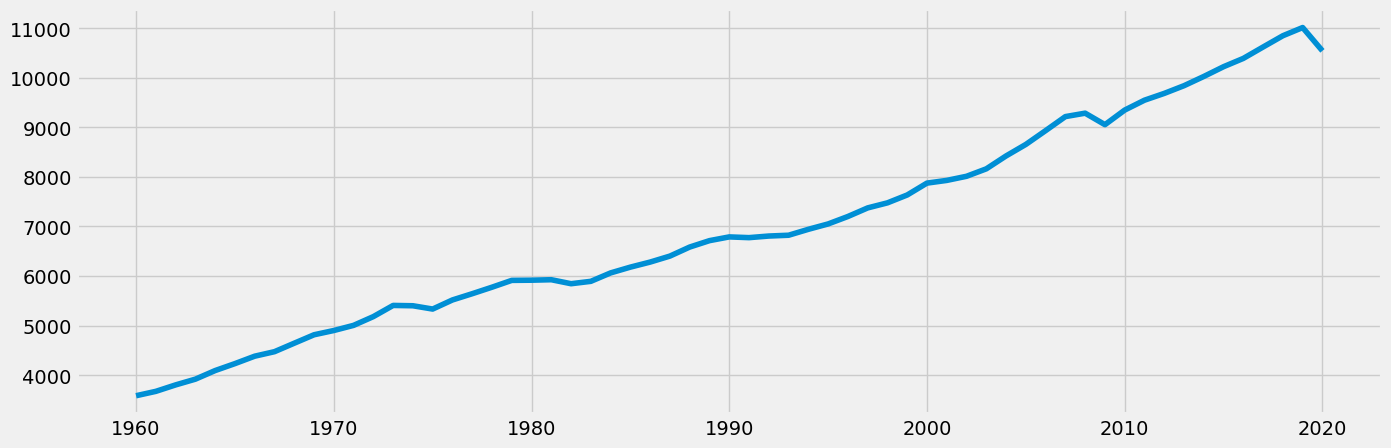

In [28]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [29]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [31]:
data_2

,Date,Value
0,1960-01-01,3585.427299
1,1961-01-01,3673.915868
2,1962-01-01,3803.787991
3,1963-01-01,3919.637966
4,1964-01-01,4093.070217
...,...,...
56,2016-01-01,10389.956148
57,2017-01-01,10620.318599
58,2018-01-01,10847.439008
59,2019-01-01,11012.355636


In [40]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2020-01-01')]

### Notes: Because the time series data set for the Constant GDP per capita for the World does not contain many rows, I felt that when selecting the data points for the subset, I needed to leave enough years to be able to see a trend (if applicable). This is why I chose to leave data from 2000-2020.

In [41]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date'])
data_sub = data_sub.set_index('datetime')
data_sub.drop(['Date'], axis=1, inplace=True)
data_sub.head()

,Value
datetime,
2000-01-01,7874.408149
2001-01-01,7929.017830
2002-01-01,8012.069283
2003-01-01,8162.244935
2004-01-01,8422.278347


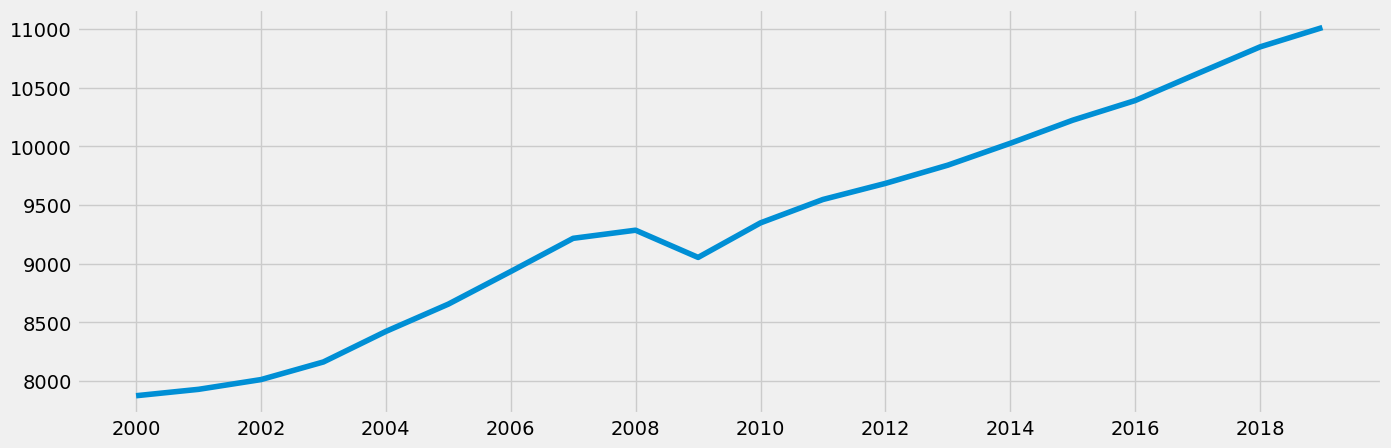

In [42]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [43]:
# Check for missing values

data_sub.isnull().sum()

Value    0
dtype: int64

#### No missing values

In [44]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

#### No duplicates

# 3. Time-series analysis: decomposition

In [45]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [46]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

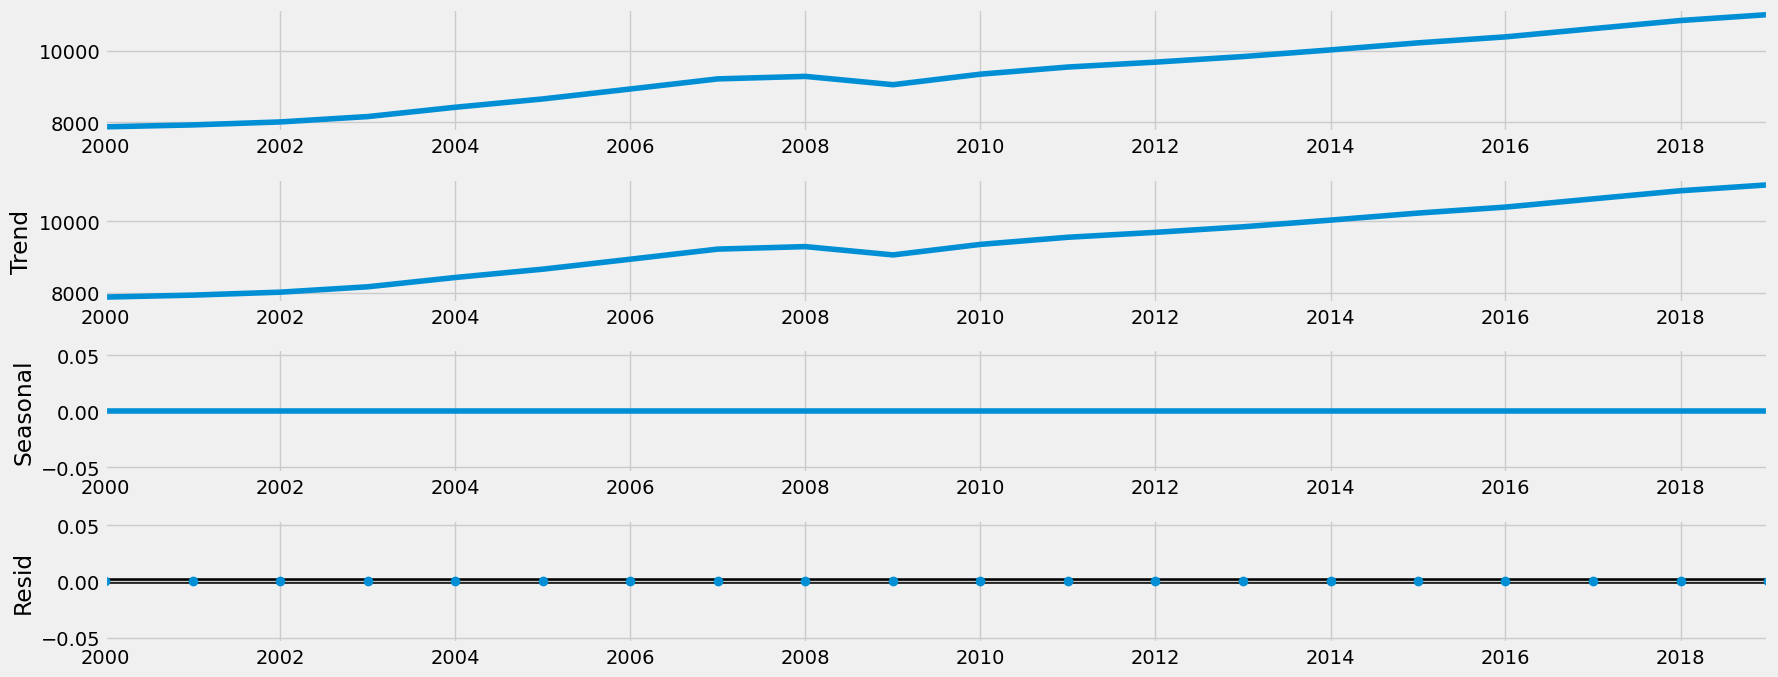

In [47]:
# Plot the separate components

decomposition.plot()
plt.show()

### Notes: The results of the decomposition are very simple and show a slight upward trend, with a slight drop in 2009, which could be because of the 2009 global financial crisis. With the top line being the original data, the trend line is the same, which tells us that our data has been smoothed. This is also why the bottom line shows no noise.
### The third component, or seasonality is flat and linear. This tells us that there is no seasonality within this data. Many times seasonality is taken out of data dealing with GDP due to the fact that it makes assessing the state of the business cycle difficult. The Bureau of Economic Analysis (BEA) uses statistical techniques to remove seasonality from its estimates of GDP. 
 Info on seasonality being removed from GDP taken from: https://www.clevelandfed.org/publications/economic-commentary/2017/ec-201706-lingering-residual-seasonality-in-gdp-growth

In [48]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  6.414988
p-value                         1.000000
Number of Lags Used             8.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


### Notes: Looking at the stats, you can see right away that the p-value is way above 0.05, which indicates that the data is not 'significant'. Also, the Test Statistics value is a lot more than any of the Critical Values, which means we cannot reject the null hypothesis.
### This also means that there is a unit root in the data and the data is non-stationary. This can also be seen by looking at the plot and seeing that the data has an upward trend.

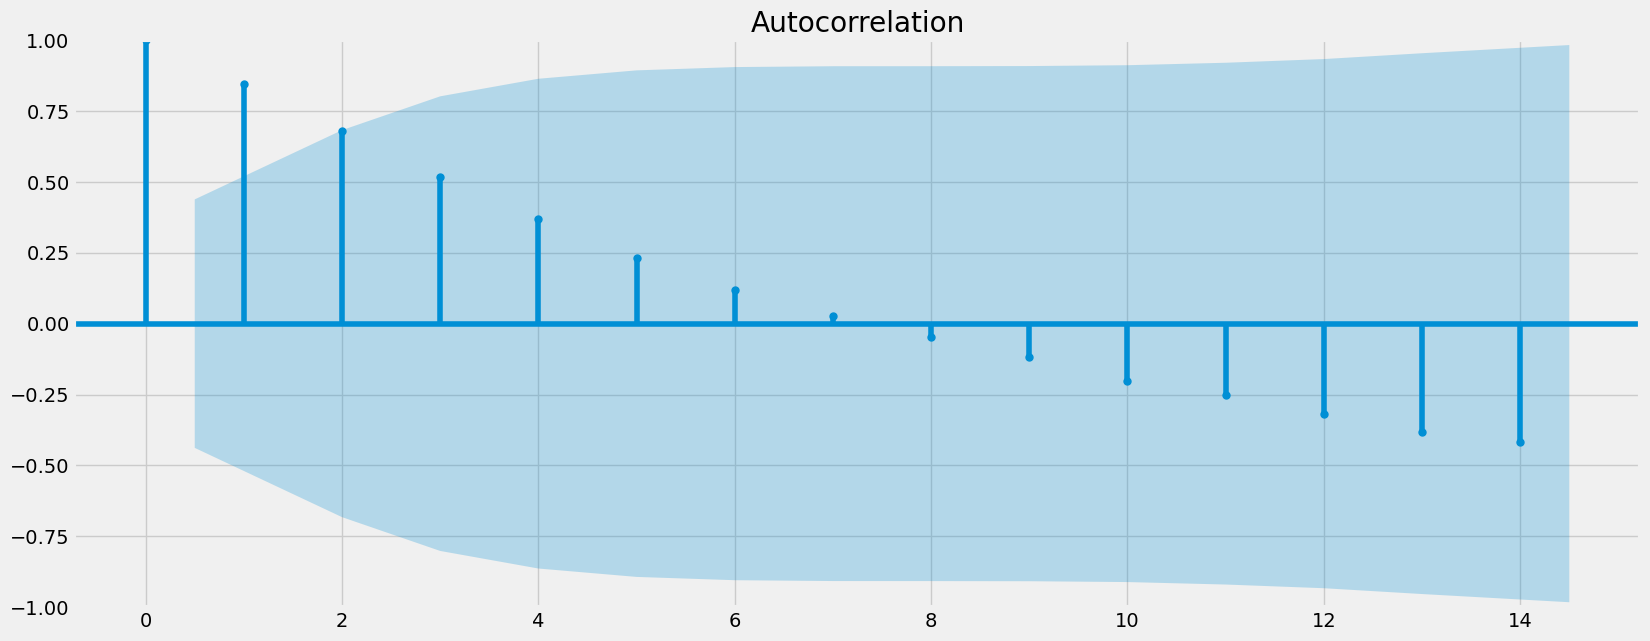

In [49]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

# 4. Stationarizing the Data

In [54]:
data_diff = data_sub - data_sub.shift(1)

In [55]:
data_diff.dropna(inplace = True)

In [56]:
data_diff.head()

,Value
datetime,
2001-01-01,54.609681
2002-01-01,83.051452
2003-01-01,150.175653
2004-01-01,260.033412
2005-01-01,233.037177


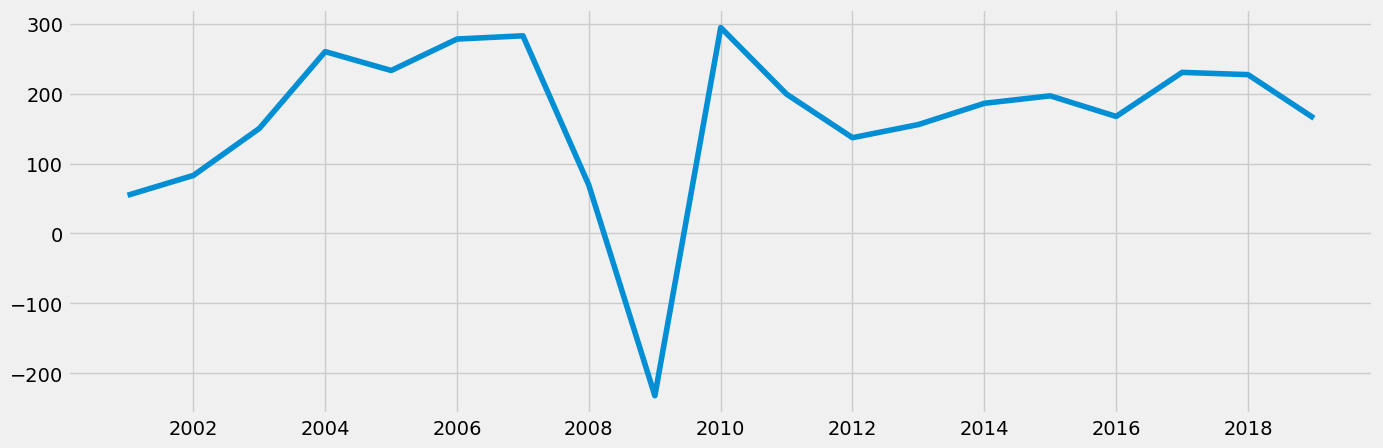

In [57]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [58]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.792933
p-value                         0.002980
Number of Lags Used             0.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


### Notes: After running a round of Differencing and the Dickey-Fuller test a second time, we can see that the Test Statistic is now smaller than the Critical Values 10% and 5%, and our p-value is well below 0.05 which means that our data is now stationary and significant. Because the data is now considered stationary, we can reject the null hypothesis.

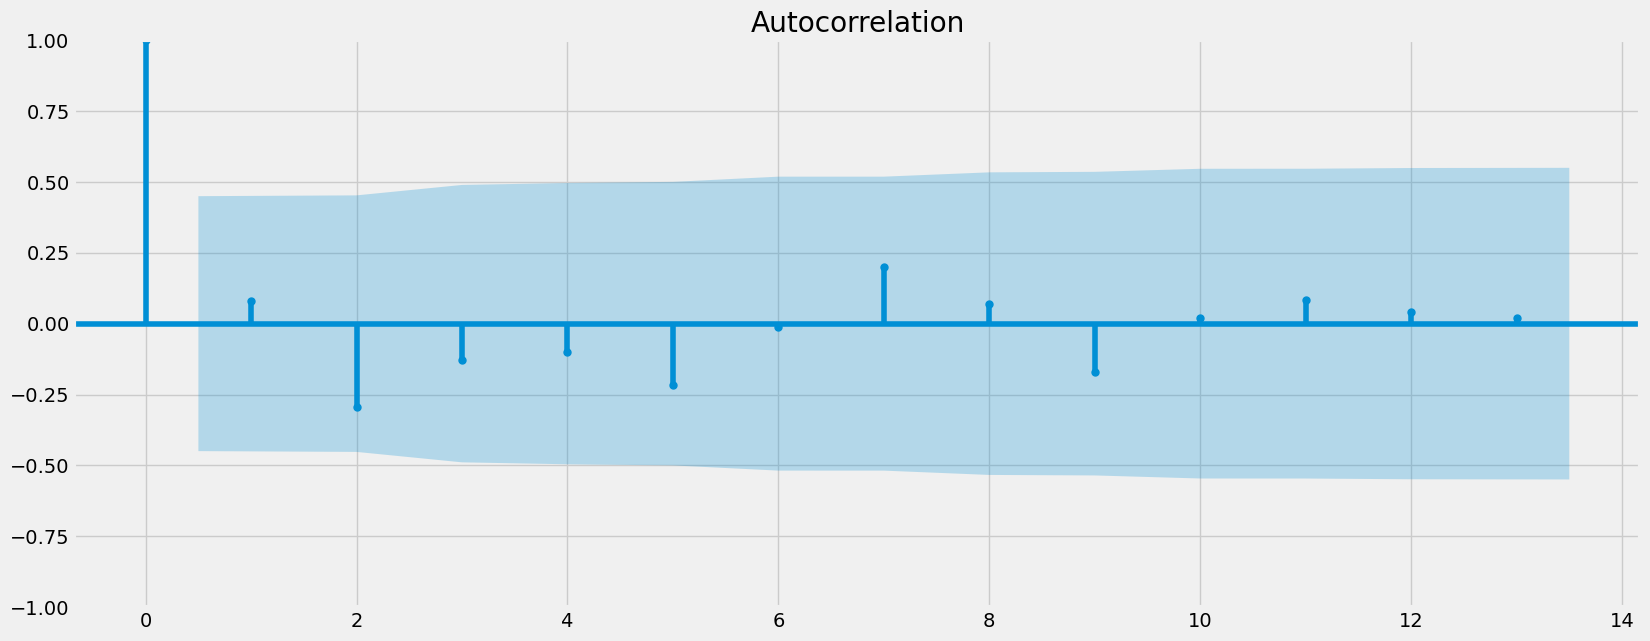

In [59]:
plot_acf(data_diff)
plt.show()